### <center>We're a consulting firm for breweries. Breweries give us their reviews and ask us to design their marketing campaign. </center>

### Introduction:
Let's say you own a brewery and you want to enter the American beer market. You were previously selling your beer in other countries and have gathered a lot of reviews on your beers. Now you want to use these reviews to design your marketing campaign in the US. 

In particular, you ask yourself:

- Will my beer be a <b>unique</b> product in the American market ? Are there beers <b>similar</b> to mine ? 
> <b> `Motivation` </b>: You want to know this in order to understand the competition you stand against. Moreover, it will help you measure how substitutable your beer is. If your beer will be unique and original in a particular state then you should market it in that state, but if its very similar to another beer then don't market it there because there's a lot of competition.

- What is the <b>most succesful</b> beer per state ? What is the aspect in which these beers excel (taste, palate) ?
> <b> `Motivation` </b>: You want to know this to understand the strength and weakness of your competitors.

- What <b>aspects of the beer profile</b> are most important (is taste more important than palate) ? 
> <b> `Motivation` </b>: You want to know this to focus your marketing on the relevant aspect. For instance, if Californians don't care about the appearance of the beer, then you shouldn't spend resources creating a nice design for your beer, focus more on the taste or palate.

- Among the beers we are most similar to, which ones can we beat ? For instance, is there a beer whose profile is similar to ours <b>but we are better in one aspect</b>? 
> <b> `Motivation` </b>: Let's say there is beer X that is very similar to ours: we score the same ratings on palate, taste and appearance. However, we notice that our aroma ratings are much higher than theirs. Then we can definitely kick beer X out of the market and win their share of beer sales. We can do this by finding where beer X is most popular and sell our product there. Consumers will find our product to be similar to beer X but has better aroma. The opposite scenario is that we are beer X. Meaning there is a competitor that is similar to us but is better in one aspect. We should be careful to not market our product in the same state as this competitor because we might lose our share of beer sales to them. 

So you turn to your team of data analysts (that's us) and you ask us to dive into the dataset and answer these questions. First, we start by translating these business questions into questions we can answer using the data. We suggest the following questions as proxies for the business needs of our brewery:

### Problem statement:
- How do we find the beers that are similar to ours ? How do we even measure <i>closeness</i> of beers ?
- How do we know which aspect is <i>important</i> for a beer aspect ?
- How do you measure the success of a certain beer ?

### Suggested solutions:
- We need to represent beers in a space that has a notion of <b> distance </b>. If we can represent each beer as a vector, then we can run <b>clustering algorithms like `K-Means`</b> to find beers that are similar to each other. Or we can run <b> `K-Nearest Neighbours` </b> to find the beers that are most similar to ours. On the same note, we can draw the <b> word-cloud </b> of the textual reviews associated to the beer, it will give the most commonly mentioned words. 

- For each beer we can run <b>`linear regression`</b> and compare the coefficients associated to each aspect. We start by learning a function $rating = w_1*palate + w_2*taste + w_3*aroma + w_4*appearance$. If $w_3$ is the biggest coefficient, then it is the most decisive aspect of the beer rating (i.e people care about the aroma aspect). We can add <b>`Lasso`</b> regularisation so that the unimportant coefficients are set automatically to zero.

- Measuring the success of a beer is simple, we just look at the proportion of high ratings. 

The first part of the notebook is dedicated to the classification task. We want to map each beer profile (taste, appearance, etc) to the state in which it is most popular. Later we can use this classifier to know in which state to market a certain beer given its profile. 

### What you'll find in this notebook:

- `read_data:` a function that extracts ratings and textual reviews and stores them in dataframes
- preprocessing and dropping of null values
- extraction of US-related data
- a way to represent beers as vectors 
- 2-dimensional representation of the space of beers and its clusters (using PCA and K-Means)
- a KNN-based function that gives the most similar beers to an input beer
- a `get_weights` function that gives the importance of each aspect of a rating
- a `word_cloud` function that fetches the textual reviews of a beer and plots its word cloud (most common words)

### We start by importing the relevant packages

In [270]:
#!pip install wordcloud

In [271]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

# Sklearn
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn import linear_model

### Then we create two dataframes to store the data of `ratings.txt` for BeerAdvocate and RateBeer.

In [282]:
def read_data(filepath, num_rows=200, extract_text_reviews=False):
    """
    Extracts reviews from .txt file and saves it into a dataframe. Converts date to readable format and store numeric values as int/float
    
    Input:
        filepath: str, path of dataset ("reviews.txt" by default)
        num_rows: int, number of rows to extract from dataset (200 by default)
        extract_text_reviews: boolean, set to True to extract text reviews as well (False by default)
        
    Return:
        df: shape: (min(num_rows, num_datapoints), 15) if extract_text_reviews=False
                   (min(num_rows, num_datapoints), 16) if extract_text_reviews=True
            contains the content of file pointed to by filepath.
    """
    # set column names
    column_names = ["beer_name", "beer_id", "brewery_name", "brewery_id", "style", "abv", "date", "user_name", "user_id", "appearance", "aroma", "palate", "taste", "overall", "rating"]
    if extract_text_reviews:
        column_names.append("text")
        #column_names.append("review")
        
    # initialise empty dataframe 
    data_dict = {col: [] for col in column_names}

    # set of numerical columns
    numerical_cols = {"abv", "appearance", "aroma", "palate", "taste", "overall", "rating", "beer_id", "brewery_id"}
    
    # read from file line by line
    with open(filepath) as data_file:
        for line in data_file:
            # skip if line is empty
            if line == '\n':
                continue
            
            # get attribute (beer_name, beer_id, etc)
            attribute = line[:line.index(':')]
        
            # skip if attribute is text 
            if attribute in {"text", "review"} and not extract_text_reviews:
                continue
            
            # extract value and convert to float if numerical attribute
            val = line[line.index(':')+2:-1]
            if attribute in numerical_cols:
                val = float(val)
                
            # add value of attribute to the corresponding list   
            data_dict[attribute].append(val)
            
            # stop reading from file if we gathered num_rows datapoints
            if (len(data_dict["text"]) == num_rows) or (len(data_dict["rating"])==num_rows and not extract_text_reviews):
                break    
    
    print([len(col) for col in data_dict.values()])
    
    # convert to dataframe            
    df = pd.DataFrame(data_dict)

    # convert unix time to readable format
    df['date'] = pd.to_datetime(df['date'],unit='s')
    
    return df

### We take a quick look on BeerAdvocate's ratings before proceeding

In [3]:
beer_advocate_path = "BeerAdvocate/ratings.txt"
df_ba = read_data(filepath=beer_advocate_path, num_rows=-1)
df_ba.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating
0,Régab,142544.0,Societe des Brasseries du Gabon (SOBRAGA),37262.0,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88
1,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67
2,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2006-03-13 11:00:00,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73
3,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-12-01 11:00:00,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98
4,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-08-30 10:00:00,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00


In [4]:
df_ba.shape

(8393032, 15)

### We also look at RateBeer's ratings

In [5]:
rate_beer_path = "RateBeer/ratings.txt"
df_rb = read_data(filepath=rate_beer_path, num_rows=-1)
df_rb.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating
0,33 Export (Gabon),410549.0,Sobraga,3198.0,Pale Lager,5.0,2016-04-26 10:00:00,Manslow,175852,2.0,4.0,2.0,4.0,8.0,2.0
1,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2017-02-17 11:00:00,MAGICuenca91,442761,2.0,3.0,2.0,4.0,8.0,1.9
2,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2016-06-24 10:00:00,Sibarh,288889,3.0,3.0,2.0,3.0,5.0,1.6
3,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2016-01-01 11:00:00,fombe89,250510,4.0,3.0,1.0,2.0,5.0,1.5
4,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2015-10-23 10:00:00,kevnic2008,122778,2.0,4.0,2.0,4.0,7.0,1.9


In [6]:
df_rb.shape

(7122074, 15)

### Since we want to only study the data of the US we add a `country` column to each dataframe. We will later this column to filter the dataset. 

### `Note:` We refer to the country of the reviewer not the brewery.

In [7]:
# for beeradvocate
users_ba = pd.read_csv("BeerAdvocate/users.csv", delimiter = ',').set_index("user_id")
df_ba['country'] = users_ba.loc[df_ba["user_id"]].location.to_list()
df_ba.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,country
0,Régab,142544.0,Societe des Brasseries du Gabon (SOBRAGA),37262.0,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"United States, Washington"
1,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,"United States, New York"
2,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2006-03-13 11:00:00,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,Northern Ireland
3,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-12-01 11:00:00,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,Northern Ireland
4,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-08-30 10:00:00,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,Northern Ireland


In [8]:
# for ratebeer
users_rb = pd.read_csv("RateBeer/users.csv", delimiter = ',')
# we notice that user_id is not unique for users.csv, therefore we must create a custom unique index
users_rb_unique = users_rb.user_id.astype('str') + users_rb.user_name
users_rb_newind = users_rb.copy()
# now we reindex the dataframe with the index we created
users_rb_newind.index = users_rb_unique
#users_rb_newind.head()

In [9]:
# we add a corresponding column to df_rb
df_rb['newind'] = df_rb.user_id.astype('str') + df_rb.user_name
df_rb['country'] = users_rb_newind.reindex(df_rb.newind).location.tolist()
df_rb.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,newind,country
0,33 Export (Gabon),410549.0,Sobraga,3198.0,Pale Lager,5.0,2016-04-26 10:00:00,Manslow,175852,2.0,4.0,2.0,4.0,8.0,2.0,175852Manslow,Poland
1,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2017-02-17 11:00:00,MAGICuenca91,442761,2.0,3.0,2.0,4.0,8.0,1.9,442761MAGICuenca91,Spain
2,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2016-06-24 10:00:00,Sibarh,288889,3.0,3.0,2.0,3.0,5.0,1.6,288889Sibarh,Poland
3,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2016-01-01 11:00:00,fombe89,250510,4.0,3.0,1.0,2.0,5.0,1.5,250510fombe89,Spain
4,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2015-10-23 10:00:00,kevnic2008,122778,2.0,4.0,2.0,4.0,7.0,1.9,122778kevnic2008,Germany


### Next, we drop the null values from each dataframe.

In [10]:
# we drop null values for each dataframe
df_ba.dropna(inplace=True)
df_ba.shape

(4451951, 16)

In [11]:
# we drop null values for each dataframe
df_rb.dropna(inplace=True)
df_rb.shape

(6746278, 17)

### Finally, we extract the data relevant to the US from each dataframe

In [12]:
# We extract the data relevant to the United States
ba_us = df_ba.loc[df_ba.country.str.startswith("United States")]
ba_us.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,country
0,Régab,142544.0,Societe des Brasseries du Gabon (SOBRAGA),37262.0,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.00,2.88,"United States, Washington"
1,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.50,3.67,"United States, New York"
12,Legbiter,19827.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.8,2013-02-13 11:00:00,brewdude1982,brewdude1982.691169,4.25,4.50,3.25,3.75,3.75,3.91,"United States, North Carolina"
13,Legbiter,19827.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.8,2013-01-09 11:00:00,AgentMunky,agentmunky.409755,4.00,3.75,3.50,3.50,3.75,3.64,"United States, New York"
17,Legbiter,19827.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.8,2012-11-17 11:00:00,ferrari29,ferrari29.320392,3.00,3.50,2.50,2.50,2.50,2.77,"United States, Illinois"


In [13]:
ba_us.shape

(4051203, 16)

In [14]:
# We extract the data relevant to the United States
rb_us = df_rb.loc[df_rb.country.str.startswith("United States")]
rb_us.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,newind,country
10,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2009-06-18 10:00:00,Cletus,17111,4.0,4.0,2.0,4.0,8.0,2.2,17111Cletus,"United States, Connecticut"
12,Régab,19445.0,Sobraga,3198.0,Pale Lager,4.5,2015-08-06 10:00:00,GenDV138,290599,3.0,5.0,3.0,5.0,10.0,2.6,290599GenDV138,"United States, Virginia"
13,Régab,19445.0,Sobraga,3198.0,Pale Lager,4.5,2015-08-02 10:00:00,nimbleprop,38859,2.0,5.0,2.0,5.0,8.0,2.2,38859nimbleprop,"United States, Washington"
14,Régab,19445.0,Sobraga,3198.0,Pale Lager,4.5,2015-08-01 10:00:00,Iphonephan,210140,2.0,3.0,3.0,3.0,9.0,2.0,210140Iphonephan,"United States, Virginia"
15,Régab,19445.0,Sobraga,3198.0,Pale Lager,4.5,2015-08-01 10:00:00,solidfunk,128160,3.0,5.0,3.0,4.0,5.0,2.0,128160solidfunk,"United States, Washington"


In [15]:
rb_us.shape

(2985941, 17)

### We give the number of reviews and number of unique beers for each dataset.

In [21]:
d = {'num_reviews':[ba_us.shape[0], rb_us.shape[0]], 'num_beers':[ba_us.groupby('beer_id').count().shape[0], rb_us.groupby('beer_id').count().shape[0]]}
summary = pd.DataFrame(data=d, index=['BeerAdvocate', 'RateBeer'])
summary

,num_reviews,num_beers
BeerAdvocate,4051203,170397
RateBeer,2985941,204575


### Now that we have preprocessed and filtered our datasets, we can start executing the plan mentioned in the introduction. 

### The first question was how to model the space of beers. First, we'll represent each review as a vector of the form `[appearance, aroma, palate, taste]`. Then we will represent each beer as the average of review vectors.

In [25]:
# first for beeradvocate
ba_average = ba_us.groupby('beer_id').mean()
beer_vecs_ba = ba_average[['appearance', 'aroma', 'palate', 'taste']]
beer_vecs_ba.head()

,appearance,aroma,palate,taste
beer_id,,,,
5.0,3.552614,3.295241,3.393097,3.420241
6.0,3.839130,3.575692,3.576680,3.678854
7.0,3.375312,3.292394,3.226517,3.215711
8.0,3.274648,3.059859,3.299296,3.239437
9.0,3.109023,2.915414,3.118421,3.097744


In [31]:
# then for ratebeer
rb_average = rb_us.groupby('beer_id').mean()
beer_vecs_rb = rb_average[['appearance', 'aroma', 'palate', 'taste']]
beer_vecs_rb.head()

,appearance,aroma,palate,taste
beer_id,,,,
1.0,4.210678,6.134199,3.432900,6.556999
2.0,3.099111,4.956798,2.808132,5.245235
3.0,3.199288,5.594306,3.085409,5.818505
4.0,3.215385,5.430769,3.041026,5.643590
5.0,3.301282,5.636752,2.837607,5.395299


### We join the two dataframes into one `beer_vecs` dataframe

In [48]:
beer_vecs = pd.concat([beer_vecs_ba, beer_vecs_rb]).groupby(level=0).mean()
beer_vecs.head()

,appearance,aroma,palate,taste
beer_id,,,,
1.0,4.210678,6.134199,3.432900,6.556999
2.0,3.099111,4.956798,2.808132,5.245235
3.0,3.199288,5.594306,3.085409,5.818505
4.0,3.215385,5.430769,3.041026,5.643590
5.0,3.426948,4.465997,3.115352,4.407770


In [51]:
beer_vecs.shape

(308659, 4)

### We have about `300,000` beer vectors. We would now like to see the distribution of our features and how they vary with respect to each other. For visualisation purposes we sample `10,000` vectors and plot their scatter matrix.

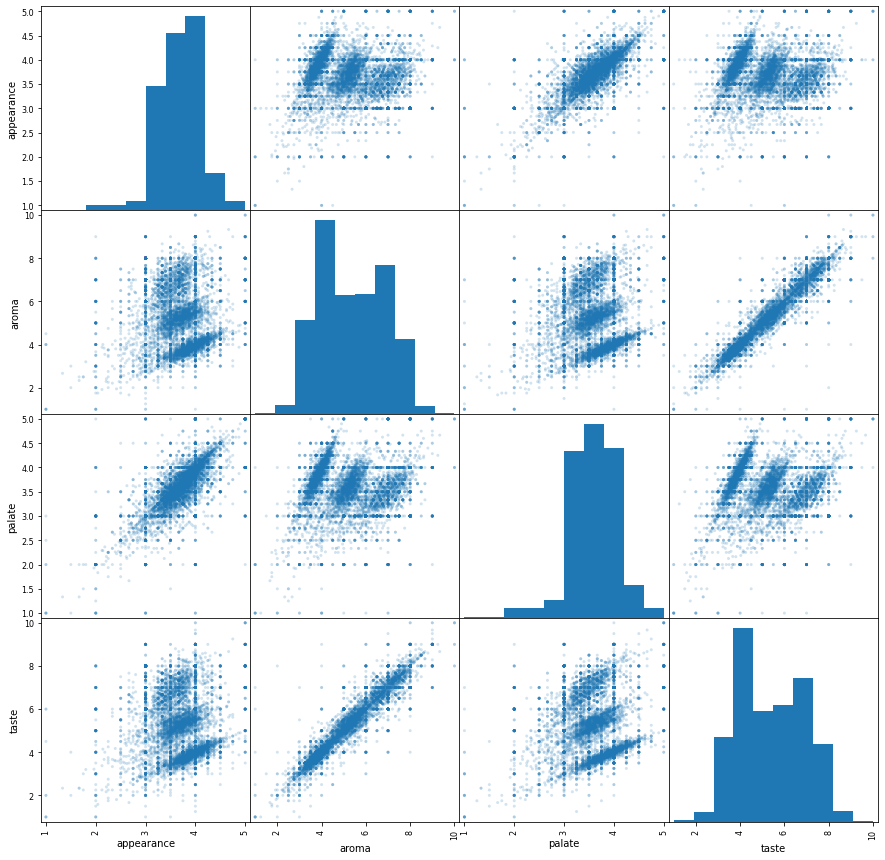

In [64]:
sample = beer_vecs.sample(n=10000)
pd.plotting.scatter_matrix(sample, alpha=0.2, figsize=(15, 15))
plt.show()

### We notice that some quadrants present 3 clusters, we want to check if the whole dataset is clustered in 3 parts. For that we use PCA to get a 2-dimensional representation of our dataset and draw its scatter plot:

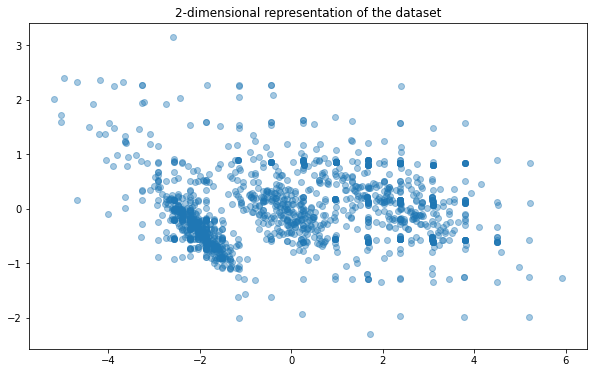

In [127]:
# First, sample some data
sample = beer_vecs.sample(n=1500)
data = np.asarray(sample)

# Run PCA 
pca = PCA(2)
transformed_data = pca.fit_transform(data)

# Draw scatter plot
plt.figure(figsize = (10, 6))
plt.scatter(x=transformed_data[:,0], y=transformed_data[:, 1], alpha=0.4)
plt.title('2-dimensional representation of the dataset')
plt.show()

### We can see that our dataset contains three distinct clusters. We can plot each cluster in a separate colour and get their centroids using K-Means.

In [128]:
kmeans = KMeans(n_clusters= 3)
label = kmeans.fit_predict(transformed_data)

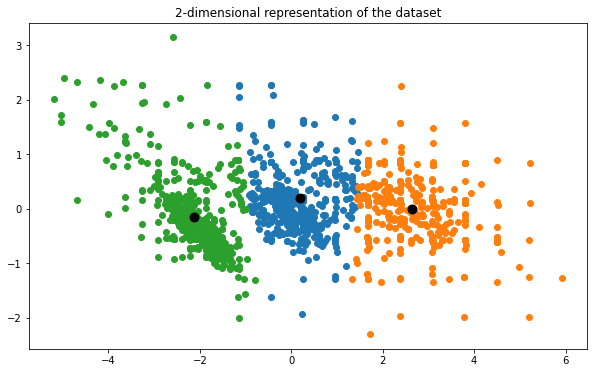

In [130]:
# Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)

# Plotting the results:
plt.figure(figsize = (10, 6))
for i in u_labels:
    plt.scatter(transformed_data[label == i , 0] , transformed_data[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.title('2-dimensional representation of the dataset')
plt.show()

### Now go back to the problem of beer similarity. We want to know which beers in our dataset are most similar (i.e have similar ratings) to our beer. Moreover, we want to know the exact profile of each of these beers. We present an implementation of KNN on the `beer_vecs` in the function below.

In [238]:
knn = NearestNeighbors()
data = np.asarray(beer_vecs)
knn.fit(data)
def find_knn(our_beer, k):
    neighbors = knn.kneighbors([our_beer], n_neighbors=k, return_distance=False)[0]
    neighbor_vecs = [data[i] for i in neighbors]
    neighbor_ids = []
    for vec in neighbor_vecs:
        for i in range(beer_vecs.shape[0]):
            if np.allclose(beer_vecs.iloc[i], vec):
                neighbor_ids.append(beer_vecs.iloc[i].name)
    neighbor_names = [rb_us.loc[rb_us.beer_id==id_].beer_name.unique()[0] for id_ in neighbor_ids]
    df = pd.DataFrame.from_dict({'neighbor_ids': neighbor_ids, 'neighbor_names': neighbor_names,
                                 'appearance': [profile[0] for profile in neighbor_vecs], 'aroma': [profile[1] for profile in neighbor_vecs], 
                                 'palate': [profile[2] for profile in neighbor_vecs], 'taste': [profile[3] for profile in neighbor_vecs]})
    return df

### The first row is associated to our beer (because it's its closest neighbor). The remaining rows present the closest neighbors and their profiles sorted by ascending distance.

In [239]:
# take beer with id = 10 as our beer
our_beer = np.array([3.62513889, 5.06340278, 3.37361111, 5.11465278])
k = 3
find_knn(our_beer, k)

,neighbor_ids,neighbor_names,appearance,aroma,palate,taste
0,11.0,Adnams Broadside (Bottle),3.625139,5.063403,3.373611,5.114653
1,84358.0,Horseheads Chocolate Porter,3.591270,5.079365,3.365079,5.107143
2,136487.0,Dieu du Ciel Rescousse,3.591463,5.039634,3.381098,5.115854


### Aspect importance using linear regression with Lasso regularization

In [262]:
def get_weights(beer_id):
    # extract data associated to beer_id
    beer_data = rb_us.loc[rb_us.beer_id==beer_id]
    # format as numpy arrays to match sklearn format
    X = np.asarray(beer_data[['appearance', 'aroma', 'palate', 'taste']])
    y = np.asarray(beer_data[['rating']])
    # instantiate a linear model with lasso regularization
    clf = linear_model.Lasso(alpha=0.1, fit_intercept=False)
    # fit model
    clf.fit(X_1, y_1)
    # return coefficients
    return clf.coef_

### For the beer Beamish Irish Stout, we see that the highest coefficient is associated to the taste feature. We can conclude that people give the most importance to the taste when rating the Beamish Irish Stout.

In [266]:
beer_id = 1.0
weights = get_weights(beer_id)
aspects = ['appearance', 'aroma', 'palate', 'taste']
print("Finding important aspect of beer: ", rb_us.loc[rb_us.beer_id==beer_id].beer_name.unique()[0])
print("Weight list: ", weights)
print("Most important aspect: ", aspects[np.argmax(weights)])

Finding important aspect of beer:  Beamish Irish Stout
Weight list:  [0.12920208 0.12585698 0.09028552 0.26689362]
Most important aspect:  taste


### `To do:` Look for beers whose reviews give the highest importance to appearance, taste and palate. Or look for negative weights

### Aspect importance using word-clouds

In [284]:
# extract text reviews
rate_beer_path = "RateBeer/ratings.txt"
rb_with_text = read_data(filepath=rate_beer_path, num_rows=-1, extract_text_reviews=True)
rb_with_text.head()

[7122074, 7122074, 7122074, 7122074, 7122074, 7122074, 7122074, 7122074, 7122074, 7122074, 7122074, 7122074, 7122074, 7122074, 7122074, 7122074]


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,33 Export (Gabon),410549.0,Sobraga,3198.0,Pale Lager,5.0,2016-04-26 10:00:00,Manslow,175852,2.0,4.0,2.0,4.0,8.0,2.0,"Puszka 0,33l dzięki Christoph . Kolor jasnozło..."
1,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2017-02-17 11:00:00,MAGICuenca91,442761,2.0,3.0,2.0,4.0,8.0,1.9,Cerveza pale lager gabonesa. MÃ¡s floja que la...
2,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2016-06-24 10:00:00,Sibarh,288889,3.0,3.0,2.0,3.0,5.0,1.6,"Kolor- złoty, klarowny. Piana - drobna, średni..."
3,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2016-01-01 11:00:00,fombe89,250510,4.0,3.0,1.0,2.0,5.0,1.5,"Botella, de GabÃ³n regalo familiar.31/01/2015C..."
4,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2015-10-23 10:00:00,kevnic2008,122778,2.0,4.0,2.0,4.0,7.0,1.9,Many thanks for this beer to Erzengel. Pours l...


In [302]:
def get_text_reviews(beer_id):
    res = rb_with_text.loc[rb_with_text.beer_id==beer_id].text.to_list()
    return res

In [317]:
def plot_word_cloud(beer_id, num_reviews=100):
    # exctract textual reviews
    reviews = get_text_reviews(beer_id)
    text = " ".join(reviews[:num_reviews])
    print("There are {} words in the combination of all reviews.".format(len(text)))
    
    # create stopword list:
    stopwords = set(STOPWORDS)
    stopwords.update(["drink", "bottle", "beer"])

    # generate a word cloud image
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

    # display the generated image:
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

There are 19964 words in the combination of all reviews.


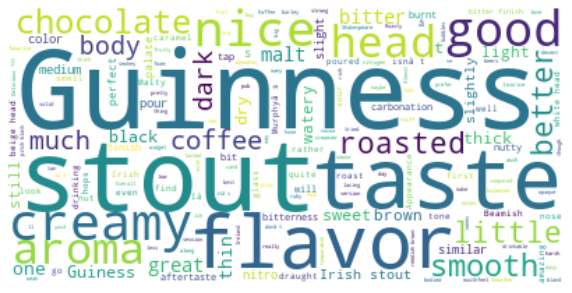

In [320]:
plot_word_cloud(1.0, 100)

# <center> Ignore cells below </center>

### We will train the classifier on the RateBeer dataset because it has more unique beers.

In [464]:
country_to_index = dict([(y,x+1) for x,y in enumerate(sorted(set(rb_us.country)))])
index_to_country = {val: key for key,val in country_index.items()}

In [514]:
# features 
features = ['beer_id', 'brewery_id', 'abv', 'appearance', 'aroma', 'taste', 'overall', 'rating']

#rb_us_shuffled = rb_us.sample(frac=1)
sample = rb_us.iloc[:10000]

# split into training and test sets with the specified features
X_train, X_test, y_train, y_test = train_test_split(sample[features], sample.country_index.values, test_size=0.2)

In [515]:
# standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [516]:
# instantiate a random classifier with the specified hyperparameters
from sklearn.svm import SVC
clf = SVC(kernel="linear", C=0.025)
    
# fit classifier on training data
clf.fit(X_train, y_train)
    
# predict test set (used when calculating the precision score)
y_pred = clf.predict(X_test)
    
# compute the precision score
precision = sklearn.metrics.precision_score(y_true=y_test, y_pred=y_pred, average='micro')
    
# compute the f1_score (used later)
f1_score = sklearn.metrics.f1_score(y_true=y_test, y_pred=y_pred, average='micro')

# compute mse
mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
    
# compute confusion matrix
#cm = confusion_matrix(y_test_new, y_pred, labels=clf.classes_)

In [517]:
precision

0.123

In [518]:
f1_score

0.123

In [519]:
mse

620.8205

In [520]:
# set up random forest hyperparameters
n_estimators = 300
criterion = 'entropy'
max_depth = 20

clf_2 = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth)

# fit classifier on training data
clf_2.fit(X_train, y_train)
    
# predict test set (used when calculating the precision score)
y_pred_2 = clf_2.predict(X_test)
    
# compute the precision score
precision_2 = sklearn.metrics.precision_score(y_true=y_test, y_pred=y_pred_2, average='micro')
    
# compute the f1_score (used later)
f1_score_2 = sklearn.metrics.f1_score(y_true=y_test, y_pred=y_pred_2, average='micro')

# compute mse
mse_2 = sklearn.metrics.mean_squared_error(y_test, y_pred_2)

In [521]:
precision_2

0.11

In [522]:
f1_score_2

0.11

In [523]:
mse_2

435.7995

In [599]:
sklearn.metrics.accuracy_score(y_true=y_test, y_pred=y_pred_2)

0.11

In [525]:
rb_california = rb_us[rb_us.country=='United States, California']
rb_california.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,newind,country,one_hot_country,country_index
1043,Hercules Yardsman,265267.0,Hercules,19638.0,Premium Lager,4.8,2014-09-23 10:00:00,hayduke,11952,3.0,7.0,4.0,7.0,15.0,3.6,11952hayduke,"United States, California","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5
1131,College Green Headless Dog,63241.0,Hilden,2099.0,Amber Ale,4.3,2014-09-22 10:00:00,hayduke,11952,3.0,7.0,4.0,7.0,13.0,3.4,11952hayduke,"United States, California","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5
1224,College Green Mollys Chocolate Stout,58329.0,Hilden,2099.0,Stout,4.3,2009-01-02 11:00:00,Ethereal,40754,4.0,7.0,4.0,8.0,17.0,4.0,40754Ethereal,"United States, California","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5
1408,Hilden Cathedral Quarter Beer,130299.0,Hilden,2099.0,Irish Ale,5.3,2014-09-21 10:00:00,hayduke,11952,3.0,7.0,3.0,7.0,13.0,3.3,11952hayduke,"United States, California","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5
1628,Hilden Number Four,203037.0,Hilden,2099.0,Bitter,4.4,2013-04-12 10:00:00,bhensonb,1966,4.0,5.0,4.0,6.0,16.0,3.5,1966bhensonb,"United States, California","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5


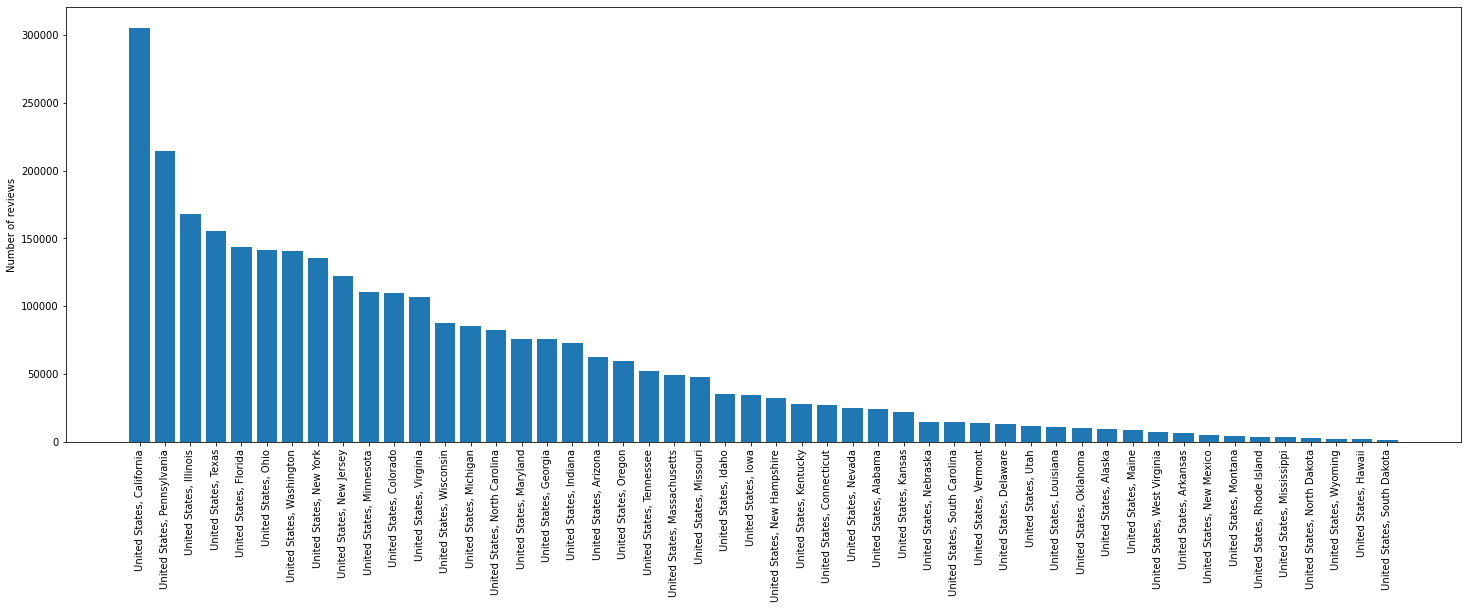

In [608]:
state_count = rb_us.groupby('country').user_id.count().sort_values(ascending=False)
fig = plt.figure(figsize = (25, 8))
plt.bar(state_count.index, state_count.values)
plt.ylabel('Number of reviews')
plt.xticks(rotation = 90)
plt.show()